# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [4]:
brain_name, brain

('TennisBrain', <unityagents.brain.BrainParameters at 0x7fc1dc084c50>)

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like: \n', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: 
 [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [6]:
# for i in range(5):                                         # play game for 5 episodes
#     env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
#     states = env_info.vector_observations                  # get the current state (for each agent)
#     scores = np.zeros(num_agents)                          # initialize the score (for each agent)
#     while True:
#         actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
#         actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
#         env_info = env.step(actions)[brain_name]           # send all actions to tne environment
#         next_states = env_info.vector_observations         # get next state (for each agent)
#         rewards = env_info.rewards                         # get reward (for each agent)
#         dones = env_info.local_done                        # see if episode finished
#         scores += env_info.rewards                         # update the score (for each agent)
#         states = next_states                               # roll over states to next time step
#         if np.any(dones):                                  # exit loop if episode finished
#             break
#     print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

When finished, you can close the environment.

In [7]:
# env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [8]:
## code to keep session awake in Udacity workspace
import signal

from contextlib import contextmanager

import requests


DELAY = INTERVAL = 4 * 60  # interval time in seconds
MIN_DELAY = MIN_INTERVAL = 2 * 60
KEEPALIVE_URL = "https://nebula.udacity.com/api/v1/remote/keep-alive"
TOKEN_URL = "http://metadata.google.internal/computeMetadata/v1/instance/attributes/keep_alive_token"
TOKEN_HEADERS = {"Metadata-Flavor":"Google"}


def _request_handler(headers):
    def _handler(signum, frame):
        requests.request("POST", KEEPALIVE_URL, headers=headers)
    return _handler


@contextmanager
def active_session(delay=DELAY, interval=INTERVAL):
    """
    Example:

    from workspace_utils import active session

    with active_session():
        # do long-running work here
    """
    token = requests.request("GET", TOKEN_URL, headers=TOKEN_HEADERS).text
    headers = {'Authorization': "STAR " + token}
    delay = max(delay, MIN_DELAY)
    interval = max(interval, MIN_INTERVAL)
    original_handler = signal.getsignal(signal.SIGALRM)
    try:
        signal.signal(signal.SIGALRM, _request_handler(headers))
        signal.setitimer(signal.ITIMER_REAL, delay, interval)
        yield
    finally:
        signal.signal(signal.SIGALRM, original_handler)
        signal.setitimer(signal.ITIMER_REAL, 0)


def keep_awake(iterable, delay=DELAY, interval=INTERVAL):
    """
    Example:

    from workspace_utils import keep_awake

    for i in keep_awake(range(5)):
        # do iteration with lots of work here
    """
    with active_session(delay, interval): yield from iterable

In [9]:
## Watch changes and reload automatically
% load_ext autoreload
% autoreload 2

In [10]:
import pdb
import json
import numpy as np 
import torch 
from collections import deque
from DDPGAgents import DDPGAgents
from utils import ensure_dir
import matplotlib.pyplot as plt

import logging
logging.basicConfig(level=logging.INFO, format='')

with open("config.json", "r") as f: 
    config = json.load(f)

In [11]:
agent = DDPGAgents(state_size=24, action_size=2, config=config)
brain_name = env.brain_names[0]

def ddpg(agent, 
         brain_name, 
         config, 
         n_episodes=config["trainer"]["num_episodes"]
         ):
    """ Deep Deterministic Policy Gradient """
    
    # Set logger for this function
    logger = logging.getLogger("ddpg")
    
    # number of agents
    num_agents = config["DDPG"]["num_agents"]
    
    max_t = 1000
    
    flag = False # When environment is technically solved
    # Save path 
    save_path = config["trainer"]["save_dir"] + config["exp_name"] + "/"
    ensure_dir(save_path)
    scores = [] # list containing scores from each episodes 
    scores_window = deque(maxlen=100)
    
    for i_episode in keep_awake(range(1, n_episodes + 1)):
        # reset the environment
        env_info = env.reset(train_mode=True)[brain_name]
        
        # reset noise
        agent.reset()
        
        # get the current state
        state = env_info.vector_observations

        # score of the agents
        score = np.zeros(num_agents)
        
        for t in range(max_t):
            # choose actions
            action = agent.act(state)
            # send the actions to the environment            
            env_info = env.step(action)[brain_name]
            # get the next state
            next_state = env_info.vector_observations
            # get the rewards
            rewards = env_info.rewards
            # see if episode has finished
            dones = env_info.local_done
            # step 
            agent.step(state, action, rewards, next_state, dones)
            # accumulate rewards into score variable
            score += rewards
            # get next_state and set it to state
            state = next_state
            
            if any(dones): 
                break
            
        # save most recent scores (mean amongst the agents)
        scores.append(np.max(score))
        scores_window.append(np.max(score))
        
        print('\rEpisode {}\tAverage Score: {:.3f}'.format(i_episode, np.mean(scores_window)), end="")
        
        if (i_episode % 100 == 0):
            print("\rEpisode {}\tAverage Score: {:.3f}".format(i_episode, \
                                                              np.mean(scores_window)))
        
        # Save occasionnaly 
        if (i_episode % config["trainer"]["save_freq"] == 0):
            torch.save(agent.actor_local.state_dict(), save_path + 
                       "checkpoint_actor_" + str(i_episode) + ".pth")
            torch.save(agent.critic_local.state_dict(), save_path + 
                       "checkpoint_critic_" + str(i_episode) + ".pth")
        
        # Check if envionment solved 
        if not flag:
            if (np.mean(scores_window) >= 0.5):
                print("\nEnvironment solved in {:d} episodes!\tAverage Score: {:.3f}".format(
                i_episode-100, np.mean(scores_window)))
                # Save solved model 
                torch.save(agent.actor_local.state_dict(), save_path + 
                          "checkpoint_actor_solved.pth")
                torch.save(agent.critic_local.state_dict(), save_path + 
                          "checkpoint_critic_solved.pth")
                flag = True
                
                break
                
    return scores
    
scores = ddpg(agent=agent, 
              brain_name=brain_name, 
              config=config)

INFO:DDPGAgents:Training on gpu
INFO:ReplayBuffer:Training on gpu


Episode 100	Average Score: 0.000
Episode 200	Average Score: 0.000
Episode 300	Average Score: 0.000
Episode 400	Average Score: 0.000
Episode 500	Average Score: 0.000
Episode 600	Average Score: 0.002
Episode 700	Average Score: 0.000
Episode 800	Average Score: 0.000
Episode 900	Average Score: 0.000
Episode 1000	Average Score: 0.000
Episode 1100	Average Score: 0.011
Episode 1200	Average Score: 0.019
Episode 1300	Average Score: 0.006
Episode 1400	Average Score: 0.029
Episode 1500	Average Score: 0.060
Episode 1600	Average Score: 0.235
Episode 1700	Average Score: 0.133
Episode 1800	Average Score: 0.168
Episode 1900	Average Score: 0.324
Episode 1909	Average Score: 0.503
Environment solved in 1809 episodes!	Average Score: 0.503


In [12]:
env.close()

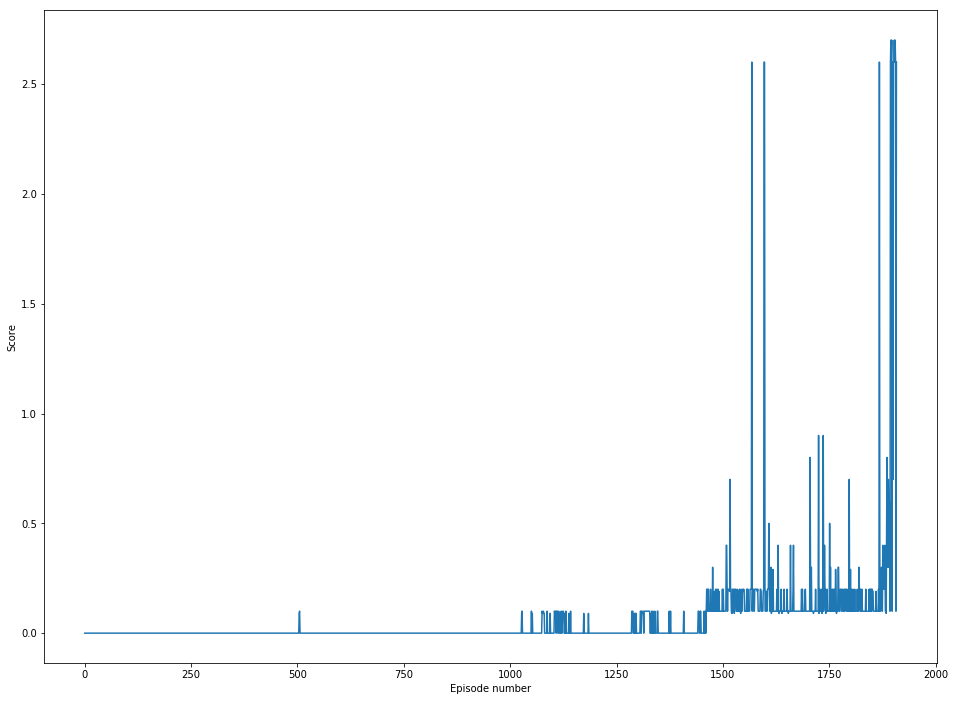

In [13]:
# plot the scores
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.xlabel('Episode number')
plt.ylabel('Score')
plt.show()